In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
def y_noise(model_func,
            x,
            noise = False):
    
    if not noise:
        y = model_func(x)
        std = None
        return y, std
    else:
        std = np.absolute(np.random.normal(loc = 0,
                          scale = 0.5,
                          size = (x.shape[0], )))
        y = model_func(x) + np.random.normal(loc = 0,
                                             scale = std,
                                             size = (x.shape[0], ))
        return y, std

In [3]:
def enkf_inverse_problem(model_func,
                         x,
                         y,
                         particles,
                         iterations,
                         noise = False,
                         std = None,
                         h_0 = 2,
                         epsilon = 0.5,
                         randomization = False
                        ):
    
    """ Ensemble Kalman Filter algorithm applied to an inverse problem.


    Parameters:

    model_func (function): Function to apply to x.
    x (np.array): True parameters.
    y (np.array): True target variable.
    particles (int): Number of particles in the ensemble.
    iterations (int): Number of iterations.
    noise (bool): Whether or not to add noise to the target variable.
    std (np.array): Standard deviation of the noise.
    h_0 (int or float): Starting step size.
    epsilon (float): Constant for numerical stability in the step size.
    randomization (bool): Whether or not to add noise to the particles and randomize them around their mean.


    Returns:

    final_params (np.ndarray): Final predicted parameter.
    loss_evolution (list): Evolution of the loss value over each iteration.
    loss_evolution_single_dict (dict): Evolutions of loss values of all particles.

    """
    
    if noise and any(std == None):
        raise ValueError("If noise is True, then std can not be None.")
    
    def loss(y_true, y_pred):
        if not noise:
            return mean_squared_error(y_true, y_pred)
        else: 
            return np.mean(np.dot(np.sqrt(np.linalg.inv(np.diag(std))), y_true - y_pred)**2)
    
    def grad_loss(y_true, y_pred):
        if not noise:
            return (-2) / y_true.shape[0] * (y_true - y_pred)
        else:
            return (-2) / y_true.shape[0] * np.diag(np.sqrt(np.linalg.inv(np.diag(std)))) * (y_true - y_pred)

    # Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
    param_dict = {}
    # Dictionary, in das für alle Partikel die predictions für y geschrieben werden
    y_pred_dict = {}
    # Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
    jacobian_dict = {}
    # Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
    loss_dict = {}

    for i in range(particles):
        param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
        y_pred_dict["particle_{}".format(i+1)] = model_func(param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = loss(y, y_pred_dict["particle_{}".format(i+1)])

    param_mean = np.mean(list(param_dict.values()), axis = 0)

    loss_evolution = []
    loss_evolution.append(loss(y, model_func(param_mean)))

    # zum Testen der einzelnen Partikel
    loss_evolution_single_dict = {}
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)] = [loss(y, model_func(param_dict["particle_{}".format(i+1)]))]

    for iteration in range(iterations):

        # update the predictions, jacobian and loss for the new parameters
        for i in range(particles):
            y_pred_dict["particle_{}".format(i+1)] = model_func(param_dict["particle_{}".format(i+1)])
            jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
            loss_dict["particle_{}".format(i+1)] = loss(y, y_pred_dict["particle_{}".format(i+1)])

        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
        d = np.transpose(d)

        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

        # matrix with particle parameters as row vectors
        params_all_ptcls = np.array(list(param_dict.values()))

        # compute the matrix with the updates for each particle
        params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)

        # write the updates back into the dictionary
        for i in range(particles):
            param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
            if randomization:
                # add randomization/ noise to each particle
                stddev = 0.1
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = param_dict["particle_{}".format(str(i+1))].shape)
                new_param = param_dict["particle_{}".format(str(i+1))] + noise
                param_dict["particle_{}".format(str(i+1))] = new_param
        if randomization:
            # randomize particles around their mean
            param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
            for i in range(particles):
                stddev = 0.1
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = param_dict["particle_{}".format(str(i+1))].shape)
                new_params = param_dict_mean + noise
                param_dict["particle_{}".format(str(i+1))] = new_params

        # compute loss for the parameter means
        param_mean = np.mean(params_all_ptcls, axis = 0)
        loss_evolution.append(loss(y, model_func(param_mean)))

        # zum Testen der einzelnen Partikel
        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(loss(y, model_func(param_dict["particle_{}".format(i+1)])))
            
        final_params = param_mean

    return final_params, loss_evolution, loss_evolution_single_dict

In [4]:
def plot_IP_loss_evolution(loss_evolution,
                           start_epoch = 0):
    
    
    """ Plot the evolution of the loss (for linear or nonlinear inverse problem).


    Parameters:

    loss_evolution (list): Evolution of the loss value over each iteration.
    start_epoch (int): First epoch to be plotted. Helpful for large difference in first and last loss value.
    

    """
    
    plt.figure(figsize = (8,5))
    plt.plot(np.arange(len(loss_evolution))[start_epoch:], 
             loss_evolution[start_epoch:], 
             marker = "s")
    plt.grid()
    plt.xlabel("Iteration")
    plt.ylabel("Mean Squared Error")
    plt.xticks(ticks = np.arange(0, len(loss_evolution), 5))
    plt.show()

In [5]:
def plot_IP_loss_evolution_many(loss_evolution_dict,
                                start_epoch = 0):
    
    
    """ Plot the evolution of the loss (for linear or nonlinear inverse problem).


    Parameters:

    loss_evolution_dict (dict): Evolution of the loss value over each iteration for each setting.
    start_epoch (int): First epoch to be plotted. Helpful for large difference in first and last loss value.
    

    """
    
    max_mse = [np.max(mse) for mse in list(loss_evolution_single_dict.values())]
    
    plt.figure(figsize = (8,5))
    for i in range(len(loss_evolution_dict)):
        plt.plot(np.arange(len(list(loss_evolution_dict.values())[i]))[start_epoch:], 
                 list(loss_evolution_dict.values())[i][start_epoch:], 
                 label = list(loss_evolution_dict.keys())[i])
    plt.grid()
    plt.xlabel("Iteration")
    plt.ylabel("Mean Squared Error")
    plt.legend(loc = "upper right")
    plt.xticks(ticks = np.arange(0, len(list(loss_evolution_dict.values())[0]), 5))
    plt.show()

In [6]:
def plot_IP_true_false(model_func,
                       final_params,
                       x,
                       y):
    
    """ Plot the true and the predicted values of the target variable (for linear or nonlinear inverse problem).


    Parameters:

        model_func (function): Function to apply to x.
        final_params (np.ndarray): Predicted parameters.
        x (np.array): True parameters.
        y (np.array): True target variables.

    """
    
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, color = "blue", s = 200, alpha = 0.5, label = "True")
    plt.scatter(x, model_func(final_params), color = "red", s = 30, label = "Predicted")
    plt.legend(loc = "upper right")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [7]:
def plot_IP_particle_loss(loss_evolution,
                          loss_evolution_single_dict):
    
    """ Plot the final loss of all particles (for linear or nonlinear inverse problem).


    Parameters:

    loss_evolution (list): Evolution of the loss value over each iteration.
    loss_evolution_single_dict (dict): Evolutions of loss values of all particles.

    """
    
    final_mse = [mse[-1] for mse in list(loss_evolution_single_dict.values())]

    plt.figure(figsize = (8,5))
    plt.scatter(np.arange(len(final_mse))+1, final_mse, alpha = 0.5, label = "Particle")
    plt.hlines(y = loss_evolution[-1], xmin = 1, xmax = len(final_mse), color = "black", label = "Mean Particle")
    plt.xticks([], [])
    plt.legend(loc = "upper right")
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom = np.min([np.min(final_mse), loss_evolution[-1]])*0.9,
             top = np.max([np.max(final_mse), loss_evolution[-1]])*1.1)
    plt.show()

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [8]:
np.random.seed(42)

In [9]:
A = np.random.uniform(size = (100, 100))
x = np.random.uniform(size = (A.shape[1], ))

In [10]:
def model_func(x):
    return np.dot(A, x)

In [11]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [12]:
iterations = 25
particles = 100
randomization = False

h_0 = 2
epsilon = 0.5

In [13]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(model_func = model_func,
                                                                                x = x,
                                                                                y = y,
                                                                                particles = particles,
                                                                                iterations = iterations,
                                                                                noise = noise,
                                                                                std = std,
                                                                                h_0 = h_0,
                                                                                epsilon = epsilon,
                                                                                randomization = randomization)

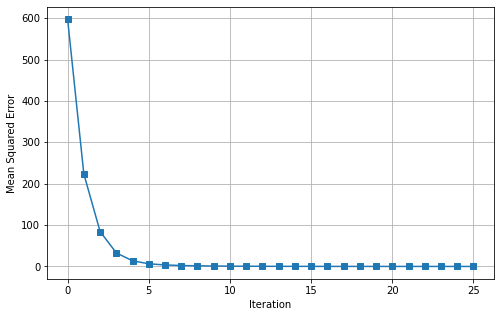

In [14]:
plot_IP_loss_evolution(loss_evolution,
                       start_epoch = 0)

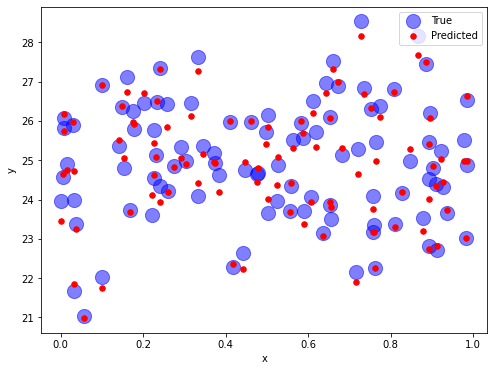

In [15]:
plot_IP_true_false(model_func,
                   final_params,
                   x,
                   y)

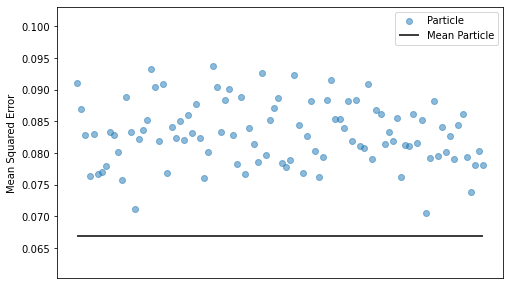

In [16]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

In [17]:
particles = [20, 40, 60, 80, 100]

loss_evolution_dict = {}

for i in range(len(particles)):
    _, loss_evolution_particles, _ = enkf_inverse_problem(model_func = model_func,
                                                          x = x,
                                                          y = y,
                                                          particles = particles[i],
                                                          iterations = iterations,
                                                          noise = noise,
                                                          std = std,
                                                          h_0 = h_0,
                                                          epsilon = epsilon,
                                                          randomization = randomization)
    loss_evolution_dict["P{}".format(particles[i])] = loss_evolution_particles

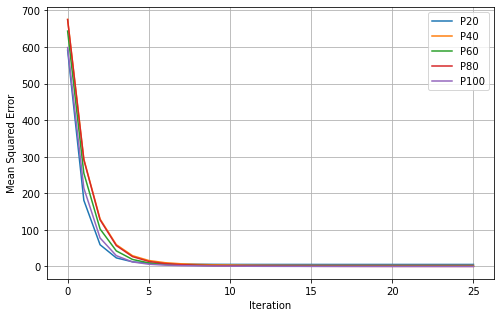

In [18]:
plot_IP_loss_evolution_many(loss_evolution_dict,
                            start_epoch = 0)

## Modell:
$Ax=y + \eta$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch), $\eta\sim\mathscr{N}(0,\Gamma)$.

$x$ wird gesucht.

In [19]:
np.random.seed(42)

In [20]:
A = np.random.uniform(size = (100, 100))
x = np.random.uniform(size = (A.shape[1], ))

In [21]:
def model_func(x):
    return np.dot(A, x)

In [22]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [23]:
iterations = 25
particles = 100
randomization = False

h_0 = 2
epsilon = 0.5

In [24]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(model_func = model_func,
                                                                                x = x,
                                                                                y = y,
                                                                                particles = particles,
                                                                                iterations = iterations,
                                                                                noise = noise,
                                                                                std = std,
                                                                                h_0 = h_0,
                                                                                epsilon = epsilon,
                                                                                randomization = randomization)

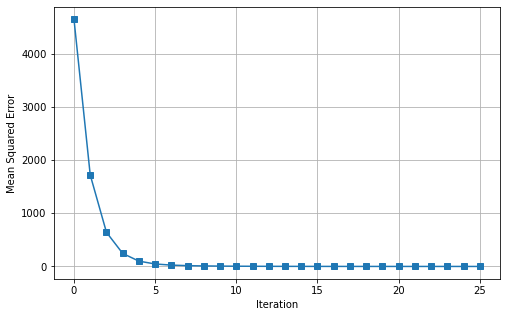

In [25]:
plot_IP_loss_evolution(loss_evolution,
                       start_epoch = 0)

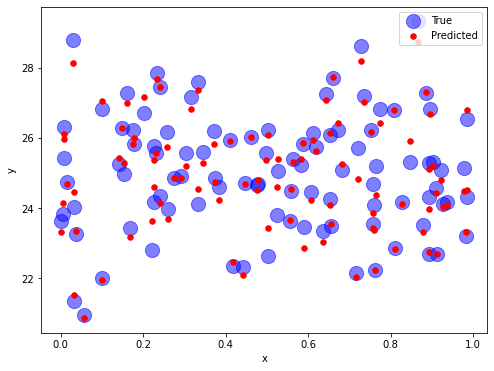

In [26]:
plot_IP_true_false(model_func,
                   final_params,
                   x,
                   y)

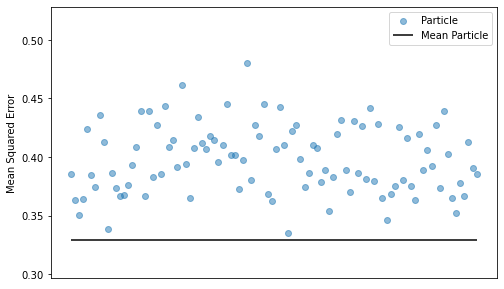

In [27]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

In [28]:
particles = [20, 40, 60, 80, 100]

loss_evolution_dict = {}

for i in range(len(particles)):
    _, loss_evolution_particles, _ = enkf_inverse_problem(model_func = model_func,
                                                          x = x,
                                                          y = y,
                                                          particles = particles[i],
                                                          iterations = iterations,
                                                          noise = noise,
                                                          std = std,
                                                          h_0 = h_0,
                                                          epsilon = epsilon,
                                                          randomization = randomization)
    loss_evolution_dict["P{}".format(particles[i])] = loss_evolution_particles

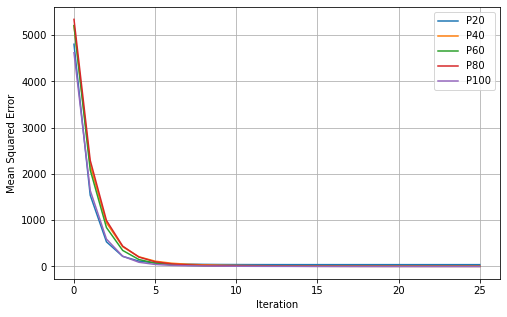

In [29]:
plot_IP_loss_evolution_many(loss_evolution_dict,
                            start_epoch = 0)

# Nichtlineares Modell

## Modell:
$sin(x)=y$

$x$ wird gesucht.

In [30]:
np.random.seed(42)

In [31]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [32]:
def model_func(x):
    return np.sin(x)

In [33]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [34]:
iterations = 25
particles = 100
randomization = False

h_0 = 2
epsilon = 0.5

In [35]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(model_func = model_func,
                                                                                x = x,
                                                                                y = y,
                                                                                particles = particles,
                                                                                iterations = iterations,
                                                                                noise = noise,
                                                                                std = std,
                                                                                h_0 = h_0,
                                                                                epsilon = epsilon,
                                                                                randomization = randomization)

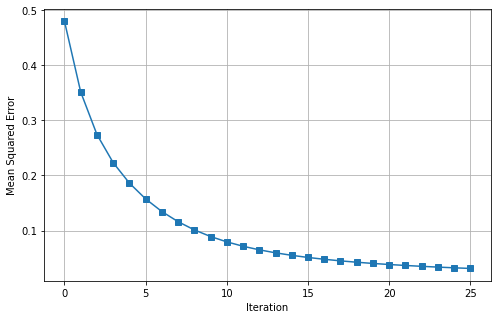

In [36]:
plot_IP_loss_evolution(loss_evolution,
                       start_epoch = 0)

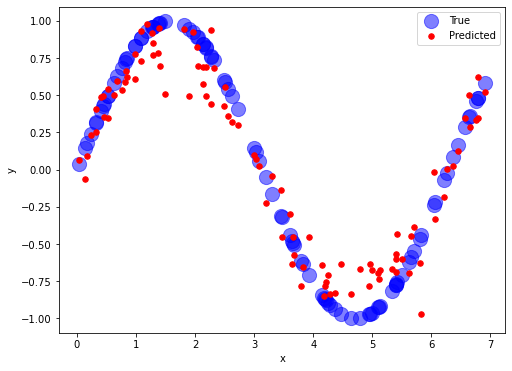

In [37]:
plot_IP_true_false(model_func,
                   final_params,
                   x,
                   y)

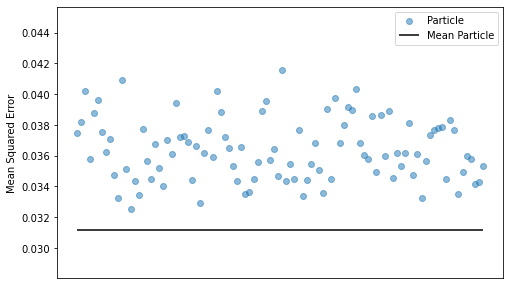

In [38]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

In [39]:
particles = [20, 40, 60, 80, 100]

loss_evolution_dict = {}

for i in range(len(particles)):
    _, loss_evolution_particles, _ = enkf_inverse_problem(model_func = model_func,
                                                          x = x,
                                                          y = y,
                                                          particles = particles[i],
                                                          iterations = iterations,
                                                          noise = noise,
                                                          std = std,
                                                          h_0 = h_0,
                                                          epsilon = epsilon,
                                                          randomization = randomization)
    loss_evolution_dict["P{}".format(particles[i])] = loss_evolution_particles

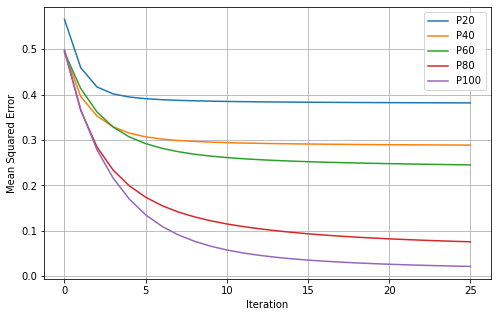

In [40]:
plot_IP_loss_evolution_many(loss_evolution_dict,
                            start_epoch = 0)

## Modell:
$\sin(x)=y + \eta$ mit $\eta\sim\mathscr{N}(0,\Gamma)$

$x$ wird gesucht.

In [41]:
np.random.seed(42)

In [42]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [43]:
def model_func(x):
    return np.sin(x)

In [44]:
noise = True

y, std = y_noise(model_func,
                 x, 
                 noise)

In [45]:
iterations = 25
particles = 100
randomization = False

h_0 = 2
epsilon = 0.5

In [46]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(model_func = model_func,
                                                                                x = x,
                                                                                y = y,
                                                                                particles = particles,
                                                                                iterations = iterations,
                                                                                noise = noise,
                                                                                std = std,
                                                                                h_0 = h_0,
                                                                                epsilon = epsilon,
                                                                                randomization = randomization)

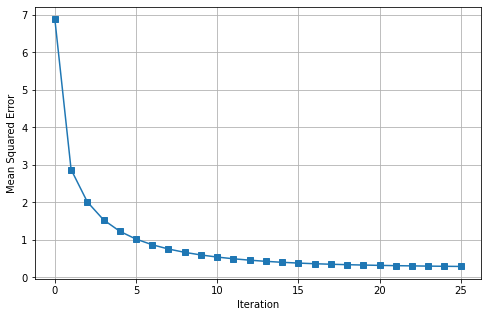

In [47]:
plot_IP_loss_evolution(loss_evolution,
                       start_epoch = 0)

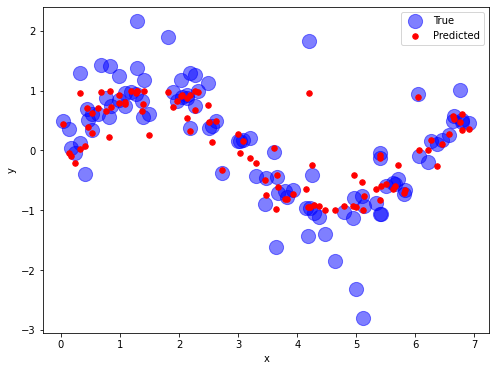

In [48]:
plot_IP_true_false(model_func,
                   final_params,
                   x,
                   y)

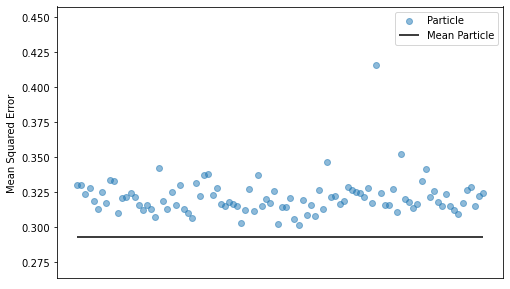

In [49]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict)

#### 5 verschiedene Partikel-Zahlen

In [50]:
particles = [20, 40, 60, 80, 100]

loss_evolution_dict = {}

for i in range(len(particles)):
    _, loss_evolution_particles, _ = enkf_inverse_problem(model_func = model_func,
                                                          x = x,
                                                          y = y,
                                                          particles = particles[i],
                                                          iterations = iterations,
                                                          noise = noise,
                                                          std = std,
                                                          h_0 = h_0,
                                                          epsilon = epsilon,
                                                          randomization = randomization)
    loss_evolution_dict["P{}".format(particles[i])] = loss_evolution_particles

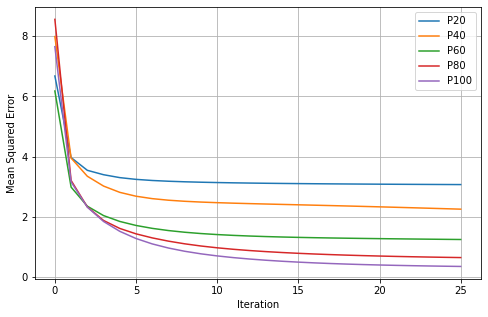

In [51]:
plot_IP_loss_evolution_many(loss_evolution_dict,
                            start_epoch = 0)